In [1]:
%load_ext autoreload
%autoreload 2

# SpookyPaiNN 


This tutorial shows how to train a PaiNN model that has some features from SpookyNet. Specifically, it borrows the following features:
1. Encodes the spin and charge of each geometry
2. Allows the charge to be spread over the molecule through non-local interactions modeled by attention 
3. Contains physics terms for nuclear-nuclear repulsion and long-range electrostatics

First we import dependencies for the tutorial:

In [2]:
import sys

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

/home/dux/NeuralForceField/models


In this tutorial we'll load an azobenzene dataset, which has ground and excited state dipoles, energies, forces, and non-adiabatic couplings. We'll use this one instead of ethanol because, unlike ethanol, it has ground state dipoles, which allow us to fit partial charges.

When making a dataset with dipoles, make sure they're in units of e Angstroms, where e is the charge of the electron (the database dipoles are in units of Debye = 0.2081943 e Angstroms).

In [3]:
DEVICE = 0
OUTDIR = "./sandbox_spooky_painn_ground_azo"
BATCH_SIZE = 32

path = "data/azobenzene.pth.tar"
dataset = Dataset.from_file(path)

###
# dataset.props['dipole_0'] = [-i for i in dataset.props['dipole_0']]
###

In addition to the usual neighbor list, we must also generate a neighbor list that has infinite cutoff (i.e. couples all pairs of atoms in each molecule) so that we can add the electrostatics terms. This neighbor list should be called `mol_nbrs`:

In [4]:
# regular neighbor list
_ = dataset.generate_neighbor_list(cutoff=5.0, undirected=False, key="nbr_list", offset_key="offsets")

# dense neighbor list
_ = dataset.generate_neighbor_list(cutoff=float("inf"), undirected=True, key="mol_nbrs", offset_key="mol_offsets")

Note also that this dataset has `charge` and `spin` as properties, which are necessary for using the SpookyNet additions to the model:


In [5]:
dataset.props.keys()

dict_keys(['force_nacv_10', 'geom_id', 'smiles', 'energy_1_grad', 'energy_0', 'energy_1', 'energy_0_grad', 'nxyz', 'num_atoms', 'energy_1_energy_0_delta', 'offsets', 'dipole_0', 'dipole_1', 'charge', 'spin', 'trans_dipole_01', 'nbr_list', 'mol_nbrs', 'q_0', 'mol_offsets'])

Now we split the dataset:

In [6]:
train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2, seed=0)

Next we make the model. If you set `non_local=True`, make sure to install [PyTorch Performer](https://github.com/lucidrains/performer-pytorch), which computes attention in order N time for N atoms. This can be done with `pip install performer-pytorch`.



In [8]:
modelparams = {
    "feat_dim": 128,
    "activation": "swish",
    "n_rbf": 20,
    "cutoff": 5.0,
    "num_conv": 3,
    "output_keys": ["energy_0"],
    "grad_keys": ["energy_0_grad"],
    # Add nuclear repulsion to the outputs with these names.
    "add_nuc_keys": ["energy_0"],
    # add atom point-charge electrostatics to the outputs
    # with these names
    "add_elec_keys": ["energy_0"],
    # add in a non-local update among all atom pairs
    # using fast attention
    "non_local": True,
    # `point_dipoles=True` means PaiNN predicts the dipole as
    # \sum_i dipole_i + \sum_i charge_i * r_i, where the first term is
    # a sum over point dipoles and the second is a sum over
    # point charges weighted by atom position. If `point_dipoles=False`
    # then the dipole is just \sum_i charge_i * r_i,
    "point_dipoles": False,
    # include point charge-point charge electrostatic interactions.
    # These energies as 1/r
    "charge_charge": True,
    # include point charge-point dipole interactions. These scale as
    # 1/r^2 and are less important. Can only be predicted if `point_dipoles
    # = True`
    "charge_dipole": False,
    # include point dipole-point dipole interactions. These scale as
    # 1/r^3 and are less important. Can only be predicted if `point_dipoles
    # = True`
    "dipole_dipole": False,
}


model = get_model(modelparams, model_type="SpookyPainn")

# untrained model to test for equivariant/invariant outputs
original_model = copy.deepcopy(model)

In the original paper there was also the option for a D4 dispersion term. This isn't implemented in our code yet, and also should probably only be used if the ground truth also contains a dispersion correction.

In [9]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), "backup")
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)

Next we make the training splits, loaders, and trainer. A few notes:
- In addition the normal force and energy loss terms, we also add a loss term for the dipole moment, so that the model can learn partial charges to reproduce the dipole.
- You may have to play around with the loss weights to figure out the best values (especially for the dipole term)
- When training with the extra terms (dipole output + electrostatic and nuclear repulsion terms), the loss drops much more slowly than for a pure ML model. You may have to train for many hundreds of epochs before you can see how well the model is doing 
- Remember to use a random sampler for the train loader, because that makes a big difference in the results (at least for small datasets)


In [10]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts, sampler=RandomSampler(train))

val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

loss_fn = loss.build_mse_loss(loss_coef={"energy_0_grad": 0.95, "energy_0": 0.05, "dipole_0": 100})

trainable_params = filter(lambda p: p.requires_grad, model.parameters())

optimizer = Adam(trainable_params, lr=1e-3)


train_metrics = [
    metrics.MeanAbsoluteError("energy_0"),
    metrics.MeanAbsoluteError("energy_0_grad"),
    metrics.MeanAbsoluteError("dipole_0"),
]


train_hooks = [
    hooks.MaxEpochHook(5000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(OUTDIR, metrics=train_metrics, separator=" | ", time_strf="%M:%S"),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        # patience in the original paper
        patience=50,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True,
    ),
]

T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks,
    mini_batches=1,
)

Now we train and see the results! The model is about 50% slower than PaiNN for azobenzene. This is mostly because of the order N^2 electrostatics terms.

In [12]:
T.train(device=DEVICE, n_epochs=100)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_dipole_0 | GPU Memory (MB)


 95%|█████████▍| 18/19 [00:05<00:00,  3.38it/s]


23:21 |     2 |     1.000e-03 | 7634824.3177 |      36355.2194 |     215.1324 |          140.9530 |       0.8700 |             672


 95%|█████████▍| 18/19 [00:04<00:00,  3.79it/s]


23:27 |     3 |     1.000e-03 | 27373.6309 |      13738.3547 |     174.7066 |           79.3694 |       0.4865 |             672


 95%|█████████▍| 18/19 [00:04<00:00,  3.90it/s]


23:32 |     4 |     1.000e-03 |  9446.1343 |       6456.4490 |      26.0631 |           57.7874 |       0.6399 |             672


 95%|█████████▍| 18/19 [00:04<00:00,  3.82it/s]


23:38 |     5 |     1.000e-03 |  5516.9885 |       4556.8497 |      27.2937 |           47.4834 |       0.6469 |             690


 95%|█████████▍| 18/19 [00:04<00:00,  3.84it/s]


23:43 |     6 |     1.000e-03 |  4195.1078 |       3754.5417 |      24.0118 |           42.4419 |       0.6236 |             690


 95%|█████████▍| 18/19 [00:04<00:00,  3.85it/s]


23:49 |     7 |     1.000e-03 |  3512.7453 |       3166.3598 |      28.0397 |           38.5765 |       0.6190 |             690


 95%|█████████▍| 18/19 [00:04<00:00,  3.93it/s]


23:54 |     8 |     1.000e-03 |  3077.5053 |       2814.0069 |      35.4701 |           36.0092 |       0.6013 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.87it/s]


24:00 |     9 |     1.000e-03 |  2777.3504 |       2553.0867 |      23.6447 |           34.3341 |       0.5992 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.84it/s]


24:05 |    10 |     1.000e-03 |  2490.9046 |       2319.2880 |      28.8929 |           32.5114 |       0.5699 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.89it/s]


24:11 |    11 |     1.000e-03 |  2295.8264 |       2127.7426 |      20.5482 |           31.1244 |       0.5532 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.77it/s]


24:16 |    12 |     1.000e-03 |  2110.3959 |       1977.4394 |      18.5712 |           29.9339 |       0.5405 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.70it/s]


24:22 |    13 |     1.000e-03 |  1957.3649 |       1861.8201 |      18.6705 |           29.1238 |       0.5261 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.68it/s]


24:28 |    14 |     1.000e-03 |  1831.5862 |       1745.1613 |      18.9703 |           27.8918 |       0.5082 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.74it/s]


24:34 |    15 |     1.000e-03 |  1718.1527 |       1633.3262 |      19.1663 |           26.9686 |       0.5034 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.81it/s]


24:39 |    16 |     1.000e-03 |  1617.8684 |       1540.6233 |      17.5399 |           26.1926 |       0.4933 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.89it/s]


24:45 |    17 |     1.000e-03 |  1526.0912 |       1460.4950 |      17.1147 |           25.4730 |       0.4721 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.94it/s]


24:50 |    18 |     1.000e-03 |  1444.8861 |       1390.7190 |      17.6208 |           24.7541 |       0.4699 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.89it/s]


24:55 |    19 |     1.000e-03 |  1372.2043 |       1358.2564 |      17.0886 |           24.7408 |       0.4551 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.78it/s]


25:01 |    20 |     1.000e-03 |  1326.6964 |       1297.5089 |      30.9657 |           23.5700 |       0.4474 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.69it/s]


25:07 |    21 |     1.000e-03 |  1259.2168 |       1218.0862 |      17.7478 |           23.1146 |       0.4420 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.77it/s]


25:12 |    22 |     1.000e-03 |  1198.3446 |       1162.1969 |      16.0855 |           22.5076 |       0.4294 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.83it/s]


25:18 |    23 |     1.000e-03 |  1147.8994 |       1116.2574 |      15.8295 |           22.1359 |       0.4163 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.84it/s]


25:24 |    24 |     1.000e-03 |  1112.5671 |       1082.9068 |      18.8566 |           21.6599 |       0.4205 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.85it/s]


25:29 |    25 |     1.000e-03 |  1072.5923 |       1038.6109 |      15.8067 |           21.2381 |       0.4066 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.80it/s]


25:35 |    26 |     1.000e-03 |  1038.4571 |       1018.6235 |      24.0141 |           20.8209 |       0.4018 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.77it/s]


25:40 |    27 |     1.000e-03 |  1003.2253 |        978.6868 |      17.1476 |           20.6137 |       0.3978 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.79it/s]


25:46 |    28 |     1.000e-03 |   963.8248 |        937.2485 |      16.3929 |           20.0664 |       0.3967 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.66it/s]


25:52 |    29 |     1.000e-03 |   933.0413 |        912.1180 |      15.0399 |           19.7711 |       0.3820 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.71it/s]


25:57 |    30 |     1.000e-03 |   913.6206 |        910.1794 |      15.7560 |           19.9931 |       0.3805 |             691


 95%|█████████▍| 18/19 [00:04<00:00,  3.75it/s]


26:03 |    31 |     1.000e-03 |   892.7508 |        870.2730 |      17.9281 |           19.3898 |       0.3801 |             691


 95%|█████████▍| 18/19 [00:05<00:00,  3.19it/s]


26:10 |    32 |     1.000e-03 |   855.1195 |        834.2382 |      14.6718 |           18.8590 |       0.3709 |             691


 95%|█████████▍| 18/19 [00:05<00:00,  3.12it/s]


26:17 |    33 |     1.000e-03 |   831.7157 |        816.0279 |      16.0781 |           18.6509 |       0.3704 |             691


 95%|█████████▍| 18/19 [00:05<00:00,  3.08it/s]


26:24 |    34 |     1.000e-03 |   809.7368 |        797.2087 |      15.1640 |           18.4722 |       0.3618 |             691


 95%|█████████▍| 18/19 [00:05<00:00,  3.23it/s]


26:30 |    35 |     1.000e-03 |   787.0886 |        789.0475 |      21.1119 |           18.3201 |       0.3540 |             691


 95%|█████████▍| 18/19 [00:06<00:00,  2.95it/s]


26:38 |    36 |     1.000e-03 |   770.0332 |        755.5017 |      15.5364 |           17.8920 |       0.3598 |             691


 95%|█████████▍| 18/19 [00:05<00:00,  3.05it/s]


26:45 |    37 |     1.000e-03 |   749.3357 |        739.8916 |      14.2181 |           17.6965 |       0.3536 |             691


 95%|█████████▍| 18/19 [00:05<00:00,  3.01it/s]


26:52 |    38 |     1.000e-03 |   745.1855 |        734.2294 |      19.1847 |           17.5209 |       0.3433 |             691


 95%|█████████▍| 18/19 [00:05<00:00,  3.22it/s]


26:58 |    39 |     1.000e-03 |   720.7940 |        712.3466 |      19.2631 |           17.2042 |       0.3422 |             691


 95%|█████████▍| 18/19 [00:05<00:00,  3.04it/s]


27:05 |    40 |     1.000e-03 |   693.6227 |        693.1477 |      18.2285 |           16.9455 |       0.3369 |             691


 95%|█████████▍| 18/19 [00:05<00:00,  3.01it/s]


27:12 |    41 |     1.000e-03 |   680.6109 |        672.8922 |      13.8080 |           16.8226 |       0.3397 |             692


 95%|█████████▍| 18/19 [00:05<00:00,  3.01it/s]


27:19 |    42 |     1.000e-03 |   667.1807 |        680.0326 |      17.0867 |           17.0219 |       0.3380 |             692


 95%|█████████▍| 18/19 [00:05<00:00,  3.20it/s]


27:26 |    43 |     1.000e-03 |   653.4463 |        669.9795 |      20.4502 |           16.7474 |       0.3293 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.93it/s]


27:33 |    44 |     1.000e-03 |   636.8892 |        633.3400 |      13.9711 |           16.2057 |       0.3300 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  3.00it/s]


27:40 |    45 |     1.000e-03 |   627.6726 |        626.2922 |      19.1840 |           15.9987 |       0.3174 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.85it/s]


27:48 |    46 |     1.000e-03 |   614.7242 |        632.8887 |      16.7607 |           16.4171 |       0.3220 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.70it/s]


27:56 |    47 |     1.000e-03 |   601.4372 |        604.9474 |      17.6405 |           15.6985 |       0.3183 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.61it/s]


28:04 |    48 |     1.000e-03 |   588.9213 |        582.0173 |      13.4096 |           15.4980 |       0.3177 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.65it/s]


28:12 |    49 |     1.000e-03 |   572.5610 |        580.0071 |      16.2675 |           15.3526 |       0.3093 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.76it/s]


28:19 |    50 |     1.000e-03 |   558.8665 |        566.5899 |      14.6070 |           15.3123 |       0.3111 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.68it/s]


28:27 |    51 |     1.000e-03 |   550.8290 |        558.7430 |      15.0489 |           15.0972 |       0.3098 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.72it/s]


28:35 |    52 |     1.000e-03 |   541.8706 |        543.0508 |      14.1270 |           14.8835 |       0.3023 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.54it/s]


28:44 |    53 |     1.000e-03 |   532.1772 |        538.3911 |      15.4126 |           14.8168 |       0.3038 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.57it/s]


28:52 |    54 |     1.000e-03 |   528.0915 |        533.4108 |      14.2773 |           14.8339 |       0.2992 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.74it/s]


29:00 |    55 |     1.000e-03 |   515.1518 |        518.4913 |      12.9044 |           14.6451 |       0.2975 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.51it/s]


29:08 |    56 |     1.000e-03 |   505.8532 |        508.1616 |      12.8367 |           14.3712 |       0.2930 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.65it/s]


29:16 |    57 |     1.000e-03 |   490.9895 |        500.7904 |      13.0578 |           14.2220 |       0.2927 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.65it/s]


29:24 |    58 |     1.000e-03 |   487.9162 |        493.7566 |      12.7941 |           14.1682 |       0.2890 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.62it/s]


29:33 |    59 |     1.000e-03 |   483.8511 |        504.3483 |      20.2825 |           14.1952 |       0.2889 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.60it/s]


29:41 |    60 |     1.000e-03 |   475.0780 |        480.2987 |      12.6207 |           14.0185 |       0.2848 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.59it/s]


29:49 |    61 |     1.000e-03 |   460.2629 |        475.7955 |      18.1477 |           13.7311 |       0.2833 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.44it/s]


29:58 |    62 |     1.000e-03 |   456.8437 |        477.0354 |      22.1858 |           13.6100 |       0.2792 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.60it/s]


30:06 |    63 |     1.000e-03 |   455.1718 |        459.2464 |      16.1128 |           13.4886 |       0.2787 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.61it/s]


30:15 |    64 |     1.000e-03 |   444.2385 |        449.2294 |      12.7164 |           13.3691 |       0.2774 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.50it/s]


30:23 |    65 |     1.000e-03 |   437.0299 |        448.8940 |      12.8974 |           13.5171 |       0.2723 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.75it/s]


30:31 |    66 |     1.000e-03 |   430.2544 |        438.6262 |      11.9862 |           13.2686 |       0.2709 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.66it/s]


30:39 |    67 |     1.000e-03 |   421.5751 |        437.9992 |      17.4316 |           13.0447 |       0.2714 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.49it/s]


30:48 |    68 |     1.000e-03 |   415.0138 |        426.9125 |      13.9783 |           12.9239 |       0.2671 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.55it/s]


30:56 |    69 |     1.000e-03 |   408.6361 |        429.5766 |      17.7763 |           13.0258 |       0.2654 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.51it/s]


31:05 |    70 |     1.000e-03 |   408.0737 |        413.1873 |      12.4091 |           12.8027 |       0.2667 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.52it/s]


31:13 |    71 |     1.000e-03 |   399.1876 |        406.7246 |      11.7370 |           12.6911 |       0.2669 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.65it/s]


31:21 |    72 |     1.000e-03 |   390.1559 |        402.7926 |      12.7219 |           12.6076 |       0.2634 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.55it/s]


31:30 |    73 |     1.000e-03 |   385.9285 |        404.5583 |      11.5457 |           12.7333 |       0.2602 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.64it/s]


31:38 |    74 |     1.000e-03 |   385.7807 |        402.6853 |      17.3692 |           12.4695 |       0.2640 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.56it/s]


31:46 |    75 |     1.000e-03 |   376.9704 |        389.5377 |      14.3203 |           12.3057 |       0.2580 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.71it/s]


31:54 |    76 |     1.000e-03 |   369.3822 |        384.2596 |      11.5061 |           12.2675 |       0.2570 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.62it/s]


32:02 |    77 |     1.000e-03 |   365.9004 |        382.8540 |      13.7535 |           12.2276 |       0.2573 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.64it/s]


32:10 |    78 |     1.000e-03 |   360.5084 |        374.3024 |      11.1809 |           12.1339 |       0.2546 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.65it/s]


32:18 |    79 |     1.000e-03 |   355.5030 |        375.5907 |      12.3018 |           12.2195 |       0.2549 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.62it/s]


32:27 |    80 |     1.000e-03 |   357.4305 |        367.8911 |      12.2820 |           11.9425 |       0.2523 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.61it/s]


32:35 |    81 |     1.000e-03 |   349.8994 |        368.0536 |      16.0532 |           11.8726 |       0.2513 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.51it/s]


32:44 |    82 |     1.000e-03 |   349.5450 |        361.8532 |      13.3598 |           11.8435 |       0.2489 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.45it/s]


32:52 |    83 |     1.000e-03 |   343.6750 |        357.4262 |      13.2770 |           11.7301 |       0.2522 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.53it/s]


33:01 |    84 |     1.000e-03 |   335.0700 |        357.6150 |      17.4957 |           11.5645 |       0.2452 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.57it/s]


33:09 |    85 |     1.000e-03 |   331.2717 |        350.7701 |      10.9160 |           11.7372 |       0.2457 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.69it/s]


33:17 |    86 |     1.000e-03 |   329.6147 |        354.6513 |      18.1748 |           11.5664 |       0.2478 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.71it/s]


33:25 |    87 |     1.000e-03 |   325.8413 |        355.4719 |      13.1985 |           12.0125 |       0.2424 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.64it/s]


33:33 |    88 |     1.000e-03 |   322.3051 |        352.1775 |      18.5338 |           11.5762 |       0.2408 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.65it/s]


33:41 |    89 |     1.000e-03 |   321.1953 |        338.6153 |      13.2573 |           11.4094 |       0.2407 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.67it/s]


33:49 |    90 |     1.000e-03 |   320.1281 |        334.3021 |      11.9650 |           11.3112 |       0.2419 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.53it/s]


33:57 |    91 |     1.000e-03 |   315.3992 |        357.9264 |      26.3304 |           11.2815 |       0.2367 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.42it/s]


34:06 |    92 |     1.000e-03 |   317.9105 |        326.5521 |      12.0261 |           11.2112 |       0.2405 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.56it/s]


34:14 |    93 |     1.000e-03 |   301.4072 |        325.3633 |      10.5363 |           11.2097 |       0.2379 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.54it/s]


34:23 |    94 |     1.000e-03 |   304.7296 |        350.3917 |      14.5075 |           12.1827 |       0.2399 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.73it/s]


34:31 |    95 |     1.000e-03 |   302.1486 |        343.5461 |      21.2130 |           11.3407 |       0.2396 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.60it/s]


34:39 |    96 |     1.000e-03 |   302.1755 |        322.0647 |      15.1806 |           10.9851 |       0.2351 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.71it/s]


34:47 |    97 |     1.000e-03 |   300.2192 |        321.8012 |      15.6230 |           10.9913 |       0.2355 |             692


 95%|█████████▍| 18/19 [00:06<00:00,  2.72it/s]


34:55 |    98 |     1.000e-03 |   296.2480 |        310.3044 |      10.5405 |           10.9003 |       0.2338 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.57it/s]


35:03 |    99 |     1.000e-03 |   289.4826 |        324.5999 |      14.0246 |           11.3728 |       0.2355 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.57it/s]


35:11 |   100 |     1.000e-03 |   287.6677 |        311.0761 |      16.3579 |           10.6466 |       0.2309 |             692


 95%|█████████▍| 18/19 [00:07<00:00,  2.52it/s]


35:20 |   101 |     1.000e-03 |   282.5584 |        305.5872 |      11.3145 |           10.8518 |       0.2329 |             692


Check that the energies are invariant to rotations and that the gradients are equivariant:

In [13]:
from numpy import cos, sin


def make_rot(alpha, beta, gamma):
    """
    Make a general rotation matrix from angles alpha, beta and gamma
    """
    r = torch.Tensor(
        [
            [
                cos(alpha) * cos(beta),
                cos(alpha) * sin(beta) * sin(gamma) - sin(alpha) * cos(gamma),
                cos(alpha) * sin(beta) * cos(gamma) + sin(alpha) * sin(gamma),
            ],
            [
                sin(alpha) * cos(beta),
                sin(alpha) * sin(beta) * sin(gamma) + cos(alpha) * cos(gamma),
                sin(alpha) * sin(beta) * cos(gamma) - cos(alpha) * sin(gamma),
            ],
            [-sin(beta), cos(beta) * sin(gamma), cos(beta) * cos(gamma)],
        ]
    )

    return r


# test that an arbitrary rotation matrix is unitary
r = make_rot(0.2, 0.1, 0.4)
print(torch.matmul(r, r.transpose(0, 1)))

tensor([[ 1.0000e+00, -1.1176e-08,  0.0000e+00],
        [-1.1176e-08,  1.0000e+00,  2.9802e-08],
        [ 0.0000e+00,  2.9802e-08,  1.0000e+00]])


In [29]:
# get results for a geometry and its rotated version

nxyz = train.props["nxyz"][0]
rots = [torch.diag(torch.ones(3)), make_rot(1.4, -0.5, 1.3)]
original_model.to(DEVICE)

for rot in rots:
    xyz = torch.stack([torch.matmul(rot, i[1:]) for i in nxyz])
    z = nxyz[:, 0].reshape(-1, 1)
    this_nxyz = torch.cat([z, xyz], dim=-1).to(DEVICE)
    batch = {
        "nxyz": this_nxyz,
        "num_atoms": torch.LongTensor([len(nxyz)]).to(DEVICE),
        "nbr_list": train.props["nbr_list"][0].to(DEVICE),
        "offsets": train.props["offsets"][0].to(DEVICE),
        "mol_nbrs": train.props["mol_nbrs"][0].to(DEVICE),
        "mol_offsets": train.props["mol_offsets"][0].to(DEVICE),
        "charge": train.props["charge"][0].to(DEVICE),
        "spin": train.props["spin"][0].to(DEVICE),
    }

    results = original_model(batch)
    energy = results["energy_0"].cpu()

    # energies should be invariant
    print("%.8f " % energy.item())

    energy_grad = results["energy_0_grad"].cpu()

    # applying R^T to the gradients should give the same value for
    # all geometries
    rot_grad = torch.stack([torch.matmul(rot.transpose(0, 1), i) for i in energy_grad])
    print(rot_grad)

2106.42382812 
tensor([[  10.3088,  -15.8060,   26.8648],
        [ -44.6376,   21.2920,  -55.0678],
        [ -62.6157,   -2.8689,  -30.3933],
        [-195.8289, -127.4109,   48.4245],
        [  31.7238,  149.6376, -243.4964],
        [  -5.9799,  291.8185,  275.1603],
        [  93.0608, -102.4742,  -31.3904],
        [  34.7657,  -71.5226,  -60.8688],
        [  35.0958,  -21.1410,    8.5763],
        [  32.1839,  -58.3511,  -26.7236],
        [  71.3416,  -37.4199,   25.4747],
        [  26.8438,   31.8473,   51.2851],
        [ -68.6924,  -35.4666,   19.2815],
        [ -10.6049,   53.6422,  -70.5964],
        [  15.4874,  -30.3055,   44.9002],
        [  -2.8384,   13.7540,  -16.5417],
        [  -1.5811,   91.1072, -111.8345],
        [ -45.2127,  -42.6813,  -80.6572],
        [  19.5790,  -95.0629,  -78.1291],
        [ -50.2620,    6.5335,  -41.0506],
        [  91.3794,   27.0434,  108.7545],
        [  18.2901,   79.4997,   86.0406],
        [  51.4559,  -35.4395,   64.460

100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


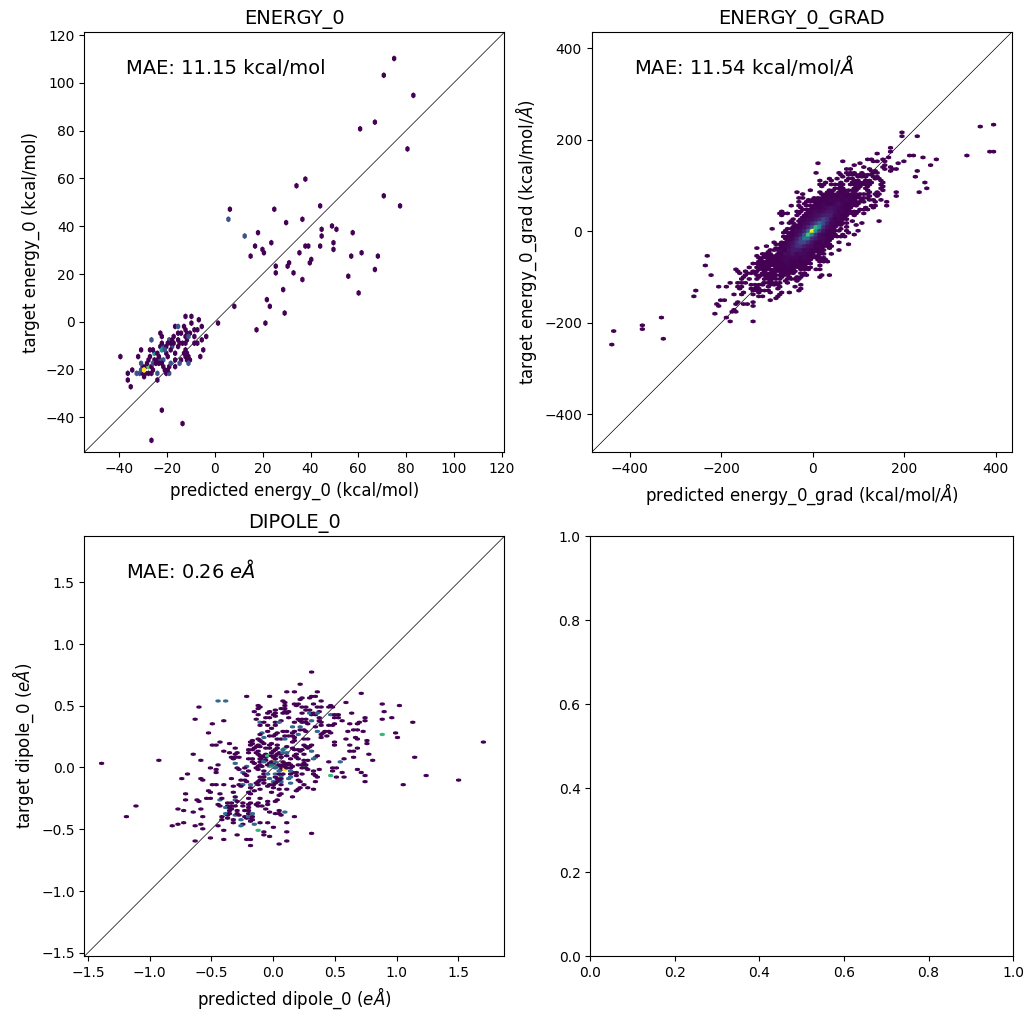

In [30]:
best_model = load_model(OUTDIR)
results, targets, val_loss = evaluate(best_model, test_loader, loss_fn, device=DEVICE)

units = {"energy_0": "kcal/mol", "energy_0_grad": r"kcal/mol/$\AA$", "dipole_0": "$e \AA$"}

fig, ax_figs = plt.subplots(2, 2, figsize=(12, 12))
all_units = list(units.keys())

for i, ax_fig in enumerate(ax_figs):
    keys = all_units[i * 2 : i * 2 + 2]

    for ax, key in zip(ax_fig, keys):
        pred_fn = torch.cat
        targ_fn = torch.cat
        if all([len(i.shape) == 0 for i in results[key]]):
            pred_fn = torch.stack
        if all([len(i.shape) == 0 for i in targets[key]]):
            targ_fn = torch.stack

        pred = pred_fn(results[key], dim=0).view(-1).detach().cpu().numpy()
        targ = targ_fn(targets[key], dim=0).view(-1).detach().cpu().numpy()

        mae = abs(pred - targ).mean()

        ax.hexbin(pred, targ, mincnt=1)

        lim_min = min(np.min(pred), np.min(targ)) * 1.1
        lim_max = max(np.max(pred), np.max(targ)) * 1.1

        ax.set_xlim(lim_min, lim_max)
        ax.set_ylim(lim_min, lim_max)
        ax.set_aspect("equal")

        ax.plot((lim_min, lim_max), (lim_min, lim_max), color="#000000", zorder=-1, linewidth=0.5)

        ax.set_title(key.upper(), fontsize=14)
        ax.set_xlabel("predicted %s (%s)" % (key, units[key]), fontsize=12)
        ax.set_ylabel("target %s (%s)" % (key, units[key]), fontsize=12)
        ax.text(0.1, 0.9, "MAE: %.2f %s" % (mae, units[key]), transform=ax.transAxes, fontsize=14)


plt.show()